In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import multiprocessing as mp
import seaborn as sns

from cvx.stat_arb.ccp import *
from cvx.stat_arb.utils import *
from cvx.stat_arb.backtest import *

sns.set()

%load_ext autoreload
%autoreload 2

In [2]:
data = pd.read_csv("../data/asset_data_2000_to_2023.csv")
data = data.drop(["TICKER", "PERMCO"], axis=1)
prices = pd.pivot_table(data, values='PRC', index='date', columns='PERMNO', fill_value=None)
prices.index = pd.to_datetime(prices.index, format="%Y-%m-%d")

prices_train = prices.loc["2022-01-01":"2022-07-31"].iloc[:,:]
prices_val = prices.loc["2022-08-01":"2022-10-31"].iloc[:,:]
prices_test = prices.loc["2022-10-01":"2022-12-31"].iloc[:,:]

prices_train_val = pd.concat([prices_train, prices_val]) # For later use

# Static (a single time period)

In [109]:
### Get list of stat arbs
stat_arb_group2 = construct_stat_arbs(prices_train, K=10, P_max=10,\
     spread_max=1, M=None, solver="ECOS")

100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


In [58]:
### Get list of stat arbs
stat_arb_group = construct_stat_arbs(prices_train, K=1000, P_max=10,\
     spread_max=1, M=None, solver="ECOS")

100%|██████████| 1000/1000 [02:29<00:00,  6.70it/s]


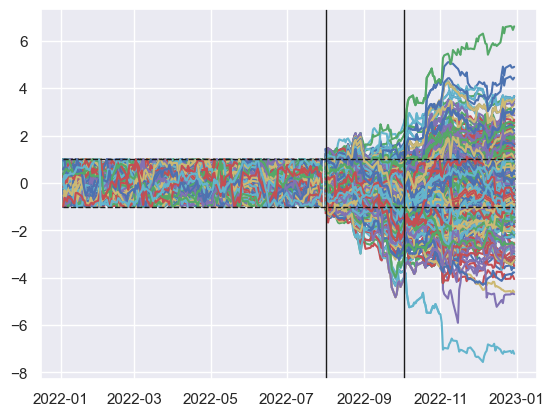

In [59]:
### Plot stat arb group
plot_all_portfolios(stat_arb_group.stat_arbs, prices_train, prices_val, prices_test)

# Trading backtest

### Using the Portfolio class

In [50]:
stat_arbs_validated = stat_arb_group.validate(prices_val,
         prices_train_val, 1.05, 3)

portfolio = stat_arbs_validated.construct_porfolio(prices_test, 1.05)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


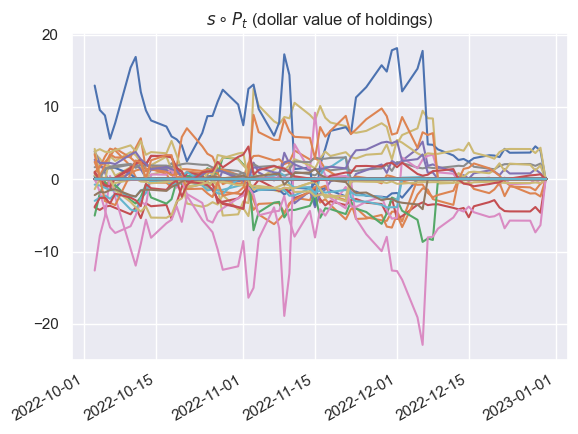

In [51]:
### Visualize portfolio holdings
holdings = portfolio.stocks * portfolio.prices
plt.plot(holdings.index, holdings);
plt.legend(holdings.columns, bbox_to_anchor=(1.05, 1), loc='upper left');
plt.title(r"$s\circ P_t$ (dollar value of holdings)");
plt.gcf().autofmt_xdate()
plt.gca().legend().remove();

In [52]:
stat_arbs_validated = stat_arb_group.validate(prices_val,
         prices_train_val, 1.05, 3)

portfolio = stat_arbs_validated.construct_porfolio(prices_test, 1.05)

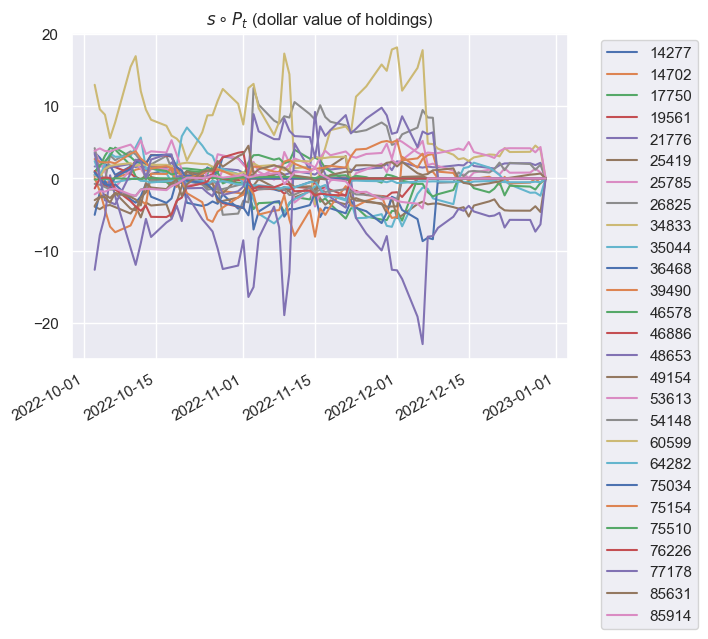

In [46]:
### Visualize portfolio holdings
holdings = portfolio.positions * portfolio.prices
plt.plot(holdings.index, holdings);
plt.legend(holdings.columns, bbox_to_anchor=(1.05, 1), loc='upper left');
plt.title(r"$s\circ P_t$ (dollar value of holdings)");
plt.gcf().autofmt_xdate()

In [53]:
m_p = Metrics(portfolio.profit)
print("profit: ", np.round(m_p.total_profit,2))
print("SR: ", np.round(m_p.sr_profit,2))

profit:  6.26
SR:  4.1


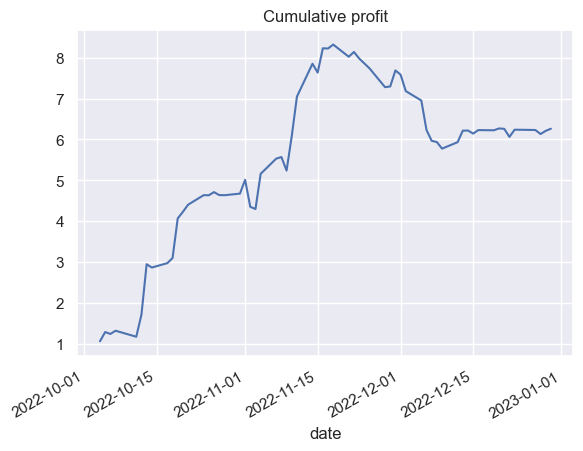

In [54]:
m_p.daily_profit.cumsum().plot(); plt.title("Cumulative profit");

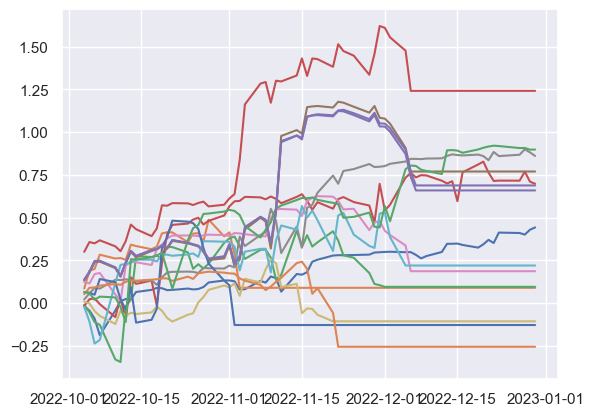

In [55]:
for stat_arb in stat_arbs_validated.stat_arbs:
    m = stat_arb.metrics(prices_test)
    if m is not None:
        plt.plot(m.daily_profit.cumsum())
        # print(m.daily_profit)

#### Using the StatArbGroup class

In [17]:
stat_arb_group = StatArbGroup(stat_arbs_validated.stat_arbs)

In [20]:
m_sg   = stat_arb_group.metrics(prices_test, cutoff=1.05)
print("profit: ", np.round(m_sg.total_profit, 2))
print("SR: ", np.round(m_sg.sr_profit,2))

profit:  6.26
SR:  4.1


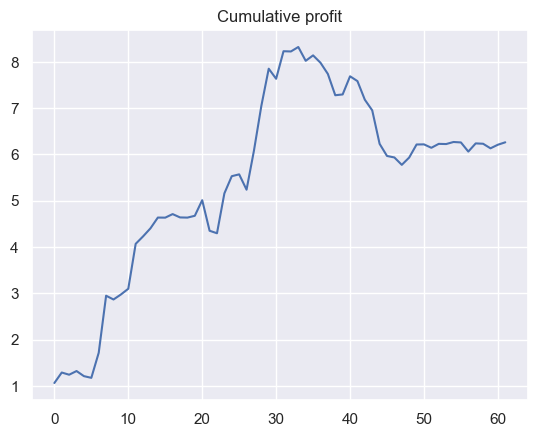

In [21]:
plt.plot(m_sg.daily_profit.cumsum().values); plt.title("Cumulative profit");

# Dynamic approach

### Find stat arbs and portfolios dynamically

In [ ]:
# K=10; P_max = 10; spread_max = 1; update_freq=pd.Timedelta(days=14);
# train_len = pd.Timedelta(days=120); val_len = pd.Timedelta(days=60);
# test_len = pd.Timedelta(days=90); M=25;
# solver="ECOS"

# SR_cutoff = 1
# cutoff = 1.5

# # Look for new stat arbs every update_freq days
# t_start = pd.Timestamp("2020-01-01")

# t_end = pd.Timestamp("2021-12-31")
# prices = prices.loc[:t_end]

# portfolios = []

# n_iters = int((prices.index[-1]-(train_len+val_len+test_len)-t_start)\
#     /update_freq)

# i=0

# all_stat_arbs = []
# all_validated_stat_arbs = []
# all_stat_arb_daily_profits = []
# while t_start < t_end-(train_len+val_len+test_len):
#     if i%10==0:
#         print(f"{i/n_iters:.0%}", end = " ")
#     i+=1
    
#     prices_train = prices.loc[t_start:t_start+train_len]
#     prices_val = prices.loc[t_start+train_len:t_start+train_len+val_len]
#     prices_test = prices.loc[t_start+train_len+val_len:\
#         t_start+train_len+val_len+test_len]

#     # Construct stat arb group
#     stat_arbs = construct_stat_arbs(prices_train, K=K, P_max=10,\
#          spread_max=spread_max, M=M, solver=solver, verbose=False)
#     stat_arb_group = StatArbGroup(stat_arbs)
#     stat_arbs_validated = stat_arb_group.validate(prices_val,
#             prices_train_val, cutoff, SR_cutoff)
#     all_validated_stat_arbs += stat_arbs_validated)

#     for stat_arb in stat_arbs_validated.stat_arbs:
#         m = stat_arb.metrics(prices_test)
#         if m is not None:
#             all_stat_arb_daily_profits.append(m.daily_profit)

#     # Construct portfolio
#     portfolio = stat_arbs_validated.construct_porfolio(prices_test, cutoff)
#     portfolios.append(portfolio)

#     # Update t_start
#     t_start += update_freq

In [55]:
K=50; P_max = 10; spread_max = 1; update_freq=pd.Timedelta(days=14);
train_len = pd.Timedelta(days=120); val_len = pd.Timedelta(days=60);
test_len = pd.Timedelta(days=90); M=50;
solver="ECOS"

SR_cutoff = 1
cutoff = 1.5

# Look for new stat arbs every update_freq days
t_start = pd.Timestamp("2020-01-01")

t_end = pd.Timestamp("2021-12-31")
prices = prices.loc[:t_end]

portfolios = []

n_iters = int((prices.index[-1]-(train_len+val_len+test_len)-t_start)\
    /update_freq)

i=0

all_stat_arbs = []
all_validated_stat_arbs = []
all_stat_arb_daily_profits = []
portfolio = None
while t_start < t_end-(train_len+val_len+test_len):
    if i%10==0:
        print(f"{i/n_iters:.0%}", end = " ")
    i+=1
    
    # Update train, val, test prices
    prices_train = prices.loc[t_start:t_start+train_len]
    prices_val = prices.loc[t_start+train_len:t_start+train_len+val_len]
    prices_test = prices.loc[t_start+train_len+val_len:\
        t_start+train_len+val_len+test_len]

    # Construct stat arb group
    stat_arb_group = construct_stat_arbs(prices_train, K=K, P_max=10,\
         spread_max=spread_max, M=M, solver=solver, verbose=False, seed=1)
    all_stat_arbs += stat_arb_group.stat_arbs
    validated_group = stat_arb_group.validate(prices_val,
            prices_train_val, cutoff, SR_cutoff)     
    all_validated_stat_arbs += validated_group.stat_arbs

    for stat_arb in validated_group.stat_arbs:
        m = stat_arb.metrics(prices_test)
        if m is not None:
            all_stat_arb_daily_profits.append(m.daily_profit)

    # Construct portfolio
    if portfolio is None:
        portfolio = validated_group.construct_porfolio(prices_test, cutoff)
        all_portfolios = [portfolio]
    else:
        portfolio_new = validated_group.construct_porfolio(prices_test, cutoff)
        if portfolio_new is not None:
            portfolio += portfolio_new
            all_portfolios.append(portfolio_new)

    # Update t_start
    t_start += update_freq

0% 31% 62% 94% 

In [56]:
m = Metrics(portfolio.profit)
print("profit: ", np.round(m.total_profit,2))
print("SR: ", np.round(m.sr_profit,2))

profit:  48.44
SR:  2.21


In [54]:
m = Metrics(portfolio.profit)
print("profit: ", np.round(m.total_profit,2))
print("SR: ", np.round(m.sr_profit,2))

profit:  57.18
SR:  2.36


In [18]:
m = Metrics(portfolio.profit)
print("profit: ", np.round(m.total_profit,2))
print("SR: ", np.round(m.sr_profit,2))

profit:  47.02
SR:  2.22


46% profitable


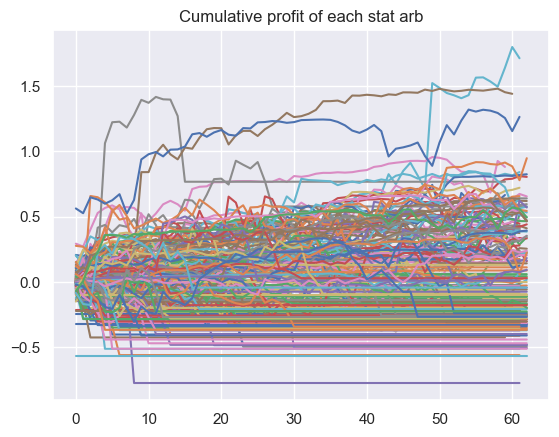

In [19]:
n_profitable = 0
avg_profits = np.zeros(90)
for profit in all_stat_arb_daily_profits:
    plt.plot(profit.cumsum().values)
    if profit.sum() > 0:
        n_profitable += 1
    avg_profits[:len(profit)] += profit
avg_profits /= len(all_stat_arb_daily_profits)
avg_profits[0] = 0
plt.title("Cumulative profit of each stat arb");
print(f"{n_profitable/len(all_stat_arb_daily_profits):.0%} profitable")

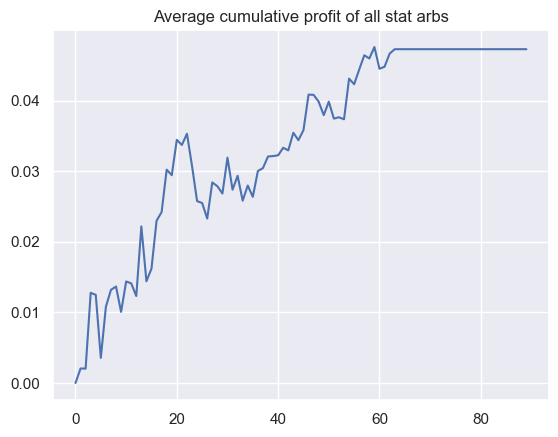

In [88]:
plt.plot(np.cumsum(avg_profits));
plt.title("Average cumulative profit of all stat arbs");

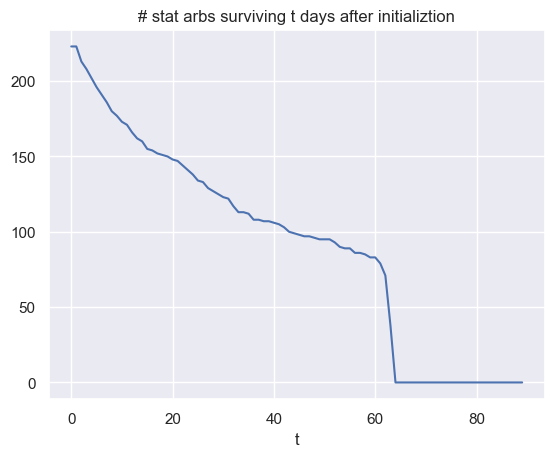

In [100]:
# Find number of survivers as a function of time
n_survivers = []
for i in range(90):
    n = 0
    for profit in all_stat_arb_daily_profits:
        if len(profit) > i:
            if profit[i] !=0:
                n+=1

    n_survivers.append(n)

plt.plot(n_survivers); plt.title("# stat arbs surviving t days after initializtion"); plt.xlabel("t");

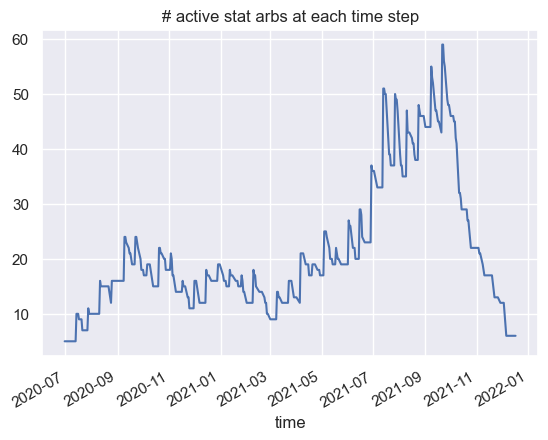

In [22]:
# Find number of active stat arbs at each time step
n_active = {}

for profit in all_stat_arb_daily_profits:
    for i in range(len(profit)):
        if profit[i] != 0:
            if profit.index[i] in n_active:
                n_active[profit.index[i]] += 1
            else:
                n_active[profit.index[i]] = 1

time_steps = list(n_active.keys())
n_active = list(n_active.values())

plt.plot(time_steps, n_active); plt.title("# active stat arbs at each time step"); plt.xlabel("time"); 

plt.gcf().autofmt_xdate()


### Sum portfolios

### Metrics

In [23]:
m = Metrics(portfolio.profit)
print("profit: ", np.round(m.total_profit,2))
print("SR: ", np.round(m.sr_profit,2))

profit:  47.02
SR:  2.22


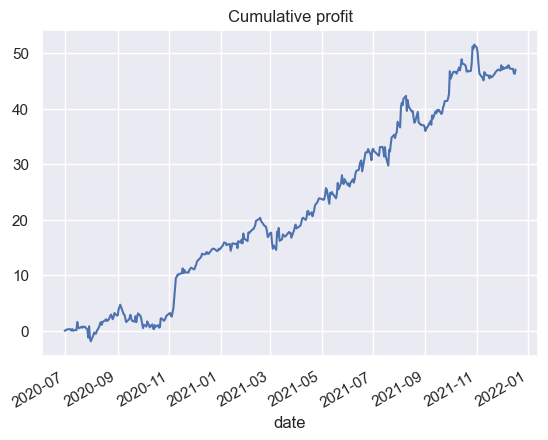

In [24]:
portfolio.profit.cumsum().plot()
plt.title("Cumulative profit");

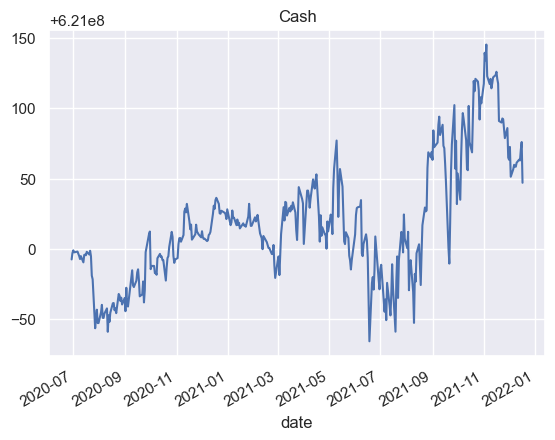

In [27]:
portfolio.cash.plot()
plt.title("Cash");

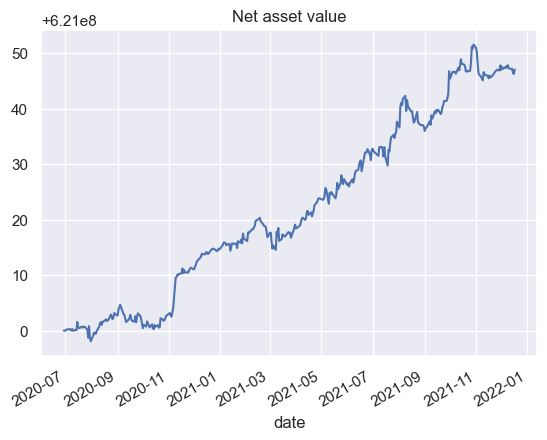

In [31]:
portfolio.nav.plot()
plt.title("Net asset value");

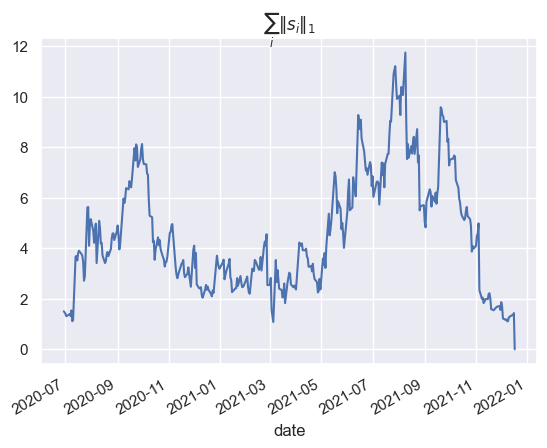

In [41]:
portfolio.stocks.abs().sum(axis=1).plot()
plt.title(r"$\sum_i\|s_i\|_1$");

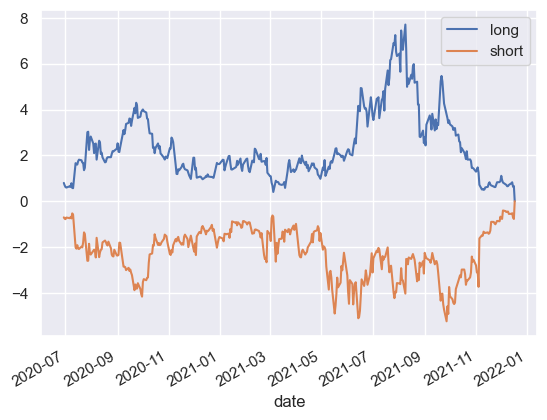

In [43]:
# Plot long positions
portfolio.stocks[portfolio.stocks>0].sum(axis=1).plot(label="long")
portfolio.stocks[portfolio.stocks<0].sum(axis=1).plot(label="short");
 plt.legend();

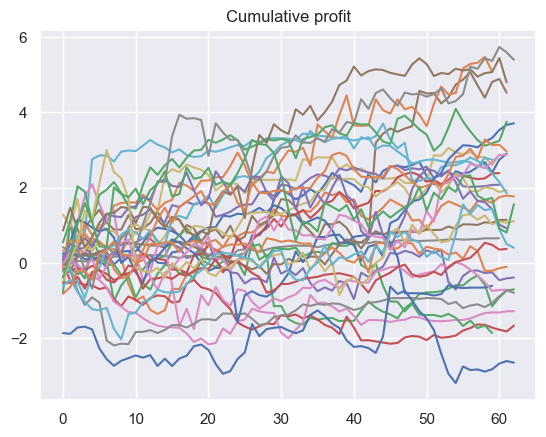

In [45]:
# Individual stat arb groups
for portfolio in all_portfolios:
    if portfolio is not None:
        m = Metrics(portfolio.profit)
        plt.plot(m.daily_profit.cumsum().values)
plt.title("Cumulative profit");

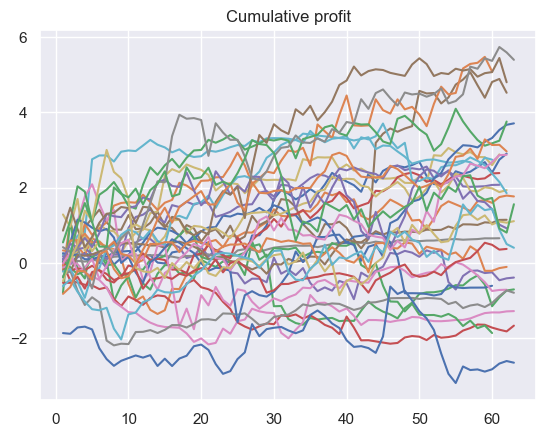

In [99]:
# Individual stat arbs
for portfolio in all_portfolios:
    if portfolio is not None:
        m = Metrics(portfolio.profit)
        plt.plot(m.daily_profit.cumsum().values)
plt.title("Cumulative profit");